In [98]:
from feedly.client import *
from feedly import *
from newspaper import Article, ArticleException
from time import sleep
import pandas as pd
import datetime

pd.set_option('max_rows',300)

In [3]:

## IAP Crds
TOKEN = "Az3LMscr9j9aXAzSsN-UNG6FMXrmJp6n9Z399dZFJ3XUoUsWjkmyso8f3ost9O0Yv1rm6VxQ5rNaERtdRr2c1Y4XDIlu5XDO-XQD_31HsUTvYFYvdqQzaDpOH7iNrvSHOdPaAKILi9CpTca2kQ82Fij6bBTwj_mc2yW2xH2XgLScogGcgZlHyKuC3xiYxS1Ys3FWtQHUBWg7noiifNFRPPTMNQgFdV6V35olZsUq-k1H9kI1qQqJVvZW:feedlydev"
FEEDLY_REDIRECT_URI = "http://fabreadly.com/auth_callback"
FEEDLY_CLIENT_ID="d8f62d80-bd91-4b23-bdc3-c219d0489a26"


# Load the Feed

Reference: [Feedly Documentation](https://developer.feedly.com/cloud/)

In [4]:
import json
import requests

# Feedly

feedaccess = TOKEN
# dktestfeedid = "user/67730c71-810b-445a-b782-3624d2d5048d/category/Sports"
adb_all_feed = 'user/d8f62d80-bd91-4b23-bdc3-c219d0489a26/category/ADB'

## Use url below to get the feed ids. 
# myurl = "http://cloud.feedly.com/v3/streams/contents?streamId=" + adb_all_feed + "&count=" + feedcount
myurl = 'https://cloud.feedly.com/v3/subscriptions'
headers = {'Authorization': 'OAuth ' + feedaccess}
res = requests.get(url=myurl, headers=headers)
con = res.json()
output = json.dumps(con , indent=4)

# See all IAP Feeds and their IDs

From the API you can pull specific feeds by ID, or you can pull everything. One issue is that IAP is also a content generator and actually pushes things to Feedly, so you also end up pulling that stuff. Anything marked EWS, or ewsdata.rightsindevelopment.org or a link to that site is an IAP generated entry, we need to filter these out. We should be able to do this faitly easily with the metadata that is available for each item. Other option is pull from a bunch of different feeds, but my guess is that filtering will actually be easier. 

Code below shows all the different feeds - the ALL feed is not listed but is coded as an option in the `pull_feed` function.

In [121]:
def see_feeds(feedaccess=feedaccess):
    myurl = 'https://cloud.feedly.com/v3/subscriptions'
    headers = {'Authorization': 'OAuth ' + feedaccess}
    res = requests.get(url=myurl, headers=headers)
    con = res.json()
    output = json.dumps(con , indent=4)
    df = pd.DataFrame([(c['title'] , c['categories'][0]['id']) for c in con])
    df.columns = ['Title','id']
    return df, con

In [122]:
df, raw  = see_feeds()

In [123]:
df.head()

,Title,id
0,All - EWS,user/d8f62d80-bd91-4b23-bdc3-c219d0489a26/cate...
1,EWS SA,user/d8f62d80-bd91-4b23-bdc3-c219d0489a26/cate...
2,ADB,user/d8f62d80-bd91-4b23-bdc3-c219d0489a26/cate...
3,WB,user/d8f62d80-bd91-4b23-bdc3-c219d0489a26/cate...
4,"Title: World Bank, Text: Loan",user/d8f62d80-bd91-4b23-bdc3-c219d0489a26/cate...


In [143]:
import math
math.ceil(10001/1000)

11

In [148]:
a = 90
if a not null:
    print('hi')

SyntaxError: invalid syntax (<ipython-input-148-f2ce61ff13c4>, line 2)

In [158]:
def pull_feed(feed_id, feedcount, all_feeds=False,  feedaccess=feedaccess):
    feedcount = str(feedcount)
    current_count = 0
    continuation_rounds = math.ceil(int(feedcount) / 1000.0)
    json_data = []
    continuation_id = None
    if all_feeds:
        feed_id = 'user/d8f62d80-bd91-4b23-bdc3-c219d0489a26/category/global.all'

    for i in range(continuation_rounds):
        print('Pulling Data - Round %s' % i)
        myurl = "http://cloud.feedly.com/v3/streams/contents?streamId=" + feed_id + "&count=" + feedcount
        
        if continuation_id:
            myurl += "&continuation={}".format(continuation_id)
        headers = {'Authorization': 'OAuth ' + feedaccess}
        res = requests.get(url=myurl, headers=headers)
        con = res.json()
        json_data.append(con)
        
        if int(feedcount) > 1000:
            print(con.keys())
            continuation_id = con['continuation']
    
    
    return json_data

In [159]:
pulled_json = pull_feed('',2000,all_feeds=True)

Pulling Data - Round 0
dict_keys(['updated', 'id', 'continuation', 'items'])
Pulling Data - Round 1
dict_keys(['updated', 'id', 'continuation', 'items'])


# Process the Feed 

Convert to a dataframe

#TODO - Figure out what tags we need to preserve here - like from which news feed were they pulled - should be valuable for identifying the bank being mentioned.  

In [167]:
def process_pulled_data(json_data):
    df_data = []
    
    for grp in range(len(json_data)):
        data = json_data[grp]
        for i in range(len(data['items'])):

            vals = data['items'][i]
            article_data = []
            article_data += [vals['published'], vals['title'],vals['alternate'][0]['href']]
            try:
                article_data.append(vals['content']['content'])
            except:
                article_data.append(None)

            try:
                article_data.append(vals['summary']['content'])
            except:
                article_data.append(None)
            df_data.append(article_data)
        
        
    df = pd.DataFrame(df_data, columns=None)
    df.columns = ['published','title','url','content','summary']
    df.published = [datetime.datetime.fromtimestamp(i/1000.0) for i in df.published]
    return df

In [168]:
test_df = process_pulled_data(pulled_json)

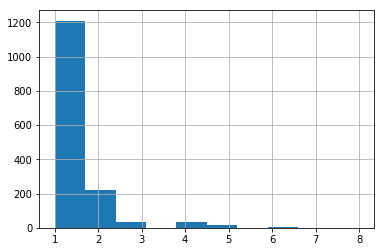

In [176]:
%matplotlib inline
test_df.url.value_counts().hist()

## Filter the Items 

In [ ]:
#TODO

## Scrape the articles

In [119]:
def get_text_via_Article(url):
    article = Article(url)
    article.download()
    try:
        article.parse()
    except ArticleException:
        print(url)
        article.download()
        print('sleeping')
        sleep(10)
    
        article.parse()
    return article.text

In [120]:
test_df['scraped_content'] = [get_text_via_Article(url) for url in test_df.url]

In [116]:
for i in test_df.scraped_content:
    print(i,'\n****')

The World Bank is to support the implementation of the Ghanaian government’s Multi-Sectorial Integrated Mining Project (MSIMP) with an investment of $50m, of which $30m will be a loan and the remaining $20m a grant.

The project aims to eliminate illegal small-scale mining – known colloquially as galamsey – in the country’s Eastern region. As part of the project, district assemblies will establish mining communities whose trained personnel will monitor sustainable mining in their districts and ensure that all local miners are registered and tracked to clamp down on illegal mining operations.

Announcing the plans, MSIMP acting national project coordinator Dr Isaac Bonsu Karikari added that the country’s ban on small-scale mining ‘would be lifted soon’, but that a date could not be given, according to the Ghana News Agency.



Small-scale mining has been banned in Ghana since January 2017, when the government put in place a six-month ban following the destruction of water resources and 

## Review Results and add in Some Language Detection

In [49]:
from langdetect import detect_langs
from langdetect.lang_detect_exception import LangDetectException

In [50]:
for i in test_df.scraped_content:
    try:
        print(detect_langs(i))
    except LangDetectException:  
        continue
    print(i,
         '\n')
    print ('*******')

[en:0.9999959709828762]
BHURBAN: The Asian Development Bank (ADB) and the Government of Pakistan have agreed to chart new ways to pursue more robust and inclusive ADB investments in the country by scaling up public-private partnerships (PPPs) to tap private sector resources and meet Pakistan’s rising infrastructure needs.

The 3-day consultation workshop, titled “ADB Country Programming and Public-Private Partnerships in Pakistan,” which started on May 14, at Bhurban near Islamabad, will be attended by over 100 delegates including senior government officials, economists, planners from federal and four provincial governments, and ADB staff. Participants will discuss development opportunities and pipeline of projects as part of ADB’s Country Operation Business Plan, 2019–2021, for Pakistan.

ADB Country Director for Pakistan Xiaohong Yang and ADB Office of Public-Private Partnerships Director Takeo Koike opened the workshop by reiterating ADB’s continued commitment to support Pakistan in

# TODO 

1. Detect Language
2. Error Test on larger set
3. Manually verify extact is generally correct 

-------------------

# End